# Functions and imports

In [1]:
%reload_ext autoreload
%autoreload 2

from copy import deepcopy
from datetime import datetime, timedelta
from file_exchange import config, network
from file_exchange.network import Network
from file_exchange.peers_view import PeersView
from file_exchange.user import User
from gevent.event import AsyncResult
from gevent.pool import Group
from gevent.select import select
import gevent
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import seaborn as sns
import shutil
import sys
import time
import traceback

def get_users_pair(users):
    u1 = random.choice(users)
    u2 = random.choice(users)
    while u1 == u2:
        u2 = random.choice(users)
    return u1, u2

def save_conf(conf):
    with open(conf['output_dir']+"conf.json", "w") as f:
        conf2 = deepcopy(conf)
        conf2['period'] = str(conf2['period'])
        json.dump(conf2, f)
def load_conf(path):
    f = open(path+'conf.json', 'r')
    conf = json.load(f)
    conf['period'] = datetime.strptime(conf['period'], "%H:%M:%S") - \
                      datetime.strptime("00:00", "%H:%M")
    return conf        

def init_dir(path):
    if path is None:
        return
    if os.path.isdir(path):
        if os.listdir(path):
            ans = input("Remove previous content of "+path+"? (y/N) ")
            if ans == 'Y' or ans == 'y' or ans == 'o' or ans == 'O':
                shutil.rmtree(path)
    if not os.path.isdir(path):
        os.makedirs(path)

class Experiment:
    def __init__(self, conf):
        self.conf = conf
        
        # Initializing stuff
        if conf['do_monitor']:
            init_dir(conf['output_dir'])
        self.address_book = PeersView(conf)
        self.net = Network()
        self.users = [None] * conf['n_users']
        for i in range(conf['n_users']):
            self.users[i] = User(self.address_book, self.net, conf)
        
    def run(self):
        t_start = time.perf_counter()
        
        # Start greenlets
        for u in self.users:
            u.start()

        # Wait a bit for everyone to register to address_book
        gevent.sleep(self.conf['period'].total_seconds()/2)
        
        # Start file exchange
        self.users_pairs = set()
        self.files_info_r = []
        while len(self.users_pairs) < self.conf['n_file_exchanges']:
            u1, u2 = get_users_pair(self.users)
            # We don't want two users to exchange files twice among them
            if (u1, u2) in self.users_pairs:
                continue
            # Now try creating the route, else try again
            try:
                file_info = u2.init_file_receive(u1)
            except Exception as e:
                print(
                    "[{}] Failed creating user pair:".format(
                        self.conf['experiment_name']), e)
                pass
            else:
                self.users_pairs.add((u1, u2))
                self.files_info_r.append(file_info)
                
                print("[{}] {} will send a file to {}.".format(
                    self.conf['experiment_name'], u1.name, u2.name))
                
        # Also fetch the sender's files_info
        self.files_info_s = [v  for u in self.users 
                           for _, v in u.sending_files.items()]
        self.n_file_exchanges = len(self.files_info_s)

        # The loop
        all_files_acknowledged = False
        while not all_files_acknowledged:
            all_files_acknowledged = all([
                finfo['f'].all_acknowledged() 
                for finfo in self.files_info_s])
            
            if all_files_acknowledged:
                break
            
            # Progression text
            completion = [None] * self.n_file_exchanges
            n_chunks = 0
            for i, finfo in enumerate(self.files_info_s):
                completion[i] = sum(finfo['f'].acked_chunks)
                n_chunks += finfo['f'].n_chunks
#                 print("[{}] File {} completed at {:.0%}.".format(
#                     self.conf['experiment_name'], finfo['f'].id, completion[i]))
            print("[{}] Files transfer at {:.0%} overall.".format(
                self.conf['experiment_name'], sum(completion) / n_chunks))
            
            # Sleep
            if not all_files_acknowledged:
                gevent.sleep(self.conf['period'].total_seconds())
        
        print("[{}] All files were acknowledged.".format(self.conf['experiment_name']))
        
        # Request for users to die
        for u in self.users:
            u.please_die()
        gevent.joinall(self.users)
        
        # Save config
        if self.conf['output_dir'] is not None:
            save_conf(self.conf)
            with open(self.conf['output_dir']+"files_info.bin", 'wb') as f:
                pickle.dump(self.files_info_s, f)

        print("[{}] Done in {:.0f}s.".format(
            self.conf['experiment_name'],
            time.perf_counter() - t_start))

# File sharing

Le temps d'échange des fichiers est proportionnel au nombre d'utilisateurs...

In [ ]:
def run_experiment_varying_users(experiment_id, n_users):
    conf = config.default
    conf['n_users'] = n_users
    conf['n_rounds'] = 200
    conf['period'] = timedelta(seconds=10)
    conf['do_monitor'] = True
    conf['experiment_id'] = experiment_id
    conf['experiment_name'] = "experiment"+str(experiment_id)+"_"+str(n_users)+"users"
    conf['output_dir'] = 'data/'+experiment_set_name+'/'+conf['experiment_name']+'/'
    conf['send_strategy'] = 'random_connected'
    conf['n_file_exchanges'] = 10
    
    experiment = Experiment(conf)
    experiment.run()

experiment_set_name = "users_number"
experiment_set = True
#N_EXPERIMENTS = 100
# couple (experiment_id, n_users) such that n_users in [5, 10, ..., 25] 
# and 100 experiments per n_users
EXPERIMENTS_PER_N_USERS = 10
N_USERS_STEP = 5
N_USERS_BINS = 10
experiment_id_n_users = [(i, N_USERS_STEP * (i % N_USERS_BINS + 1)) \
     for i in range(N_USERS_BINS*EXPERIMENTS_PER_N_USERS)]

input('Ready?')
if os.path.isdir('data/'+experiment_set_name+'/'):
    shutil.rmtree('data/'+experiment_set_name+'/')
with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
    #p.map(run_experiment, range(1, N_EXPERIMENTS+1))
    p.starmap(run_experiment_varying_users, experiment_id_n_users)

Ready?
min_file_size: 51200, max_file_size: 51200
[experiment0_5users] Stephany will send a file to Maxwell.
min_file_size: 51200, max_file_size: 51200
[experiment0_5users] Maxwell will send a file to Queen.
min_file_size: 51200, max_file_size: 51200


In [ ]:
experiment_set_name = "random_file_size"
experiment_set = True

count_finished = multiprocessing.Value('I')
def run_experiments(experiment_id):
    conf = config.default
    conf['n_users'] = 20
    conf['n_rounds'] = 200
    conf['period'] = timedelta(seconds=10)
    conf['do_monitor'] = True
    conf['experiment_id'] = experiment_id
    conf['min_file_size']= 5120  # kB
    conf['max_file_size']= 512000  # kB']
    conf['experiment_name'] = "experiment"+str(experiment_id)
    conf['output_dir'] = 'data/'+experiment_set_name+'/'+conf['experiment_name']+'/'
    conf['send_strategy'] = 'random_connected'
    conf['n_file_exchanges'] = 10
    
    experiment = Experiment(conf)
    experiment.run()
    with count_finished.get_lock():
        count_finished.value += 1
        print("[{:.0%}] done overall!".format(count_finished.value/N_EXPERIMENTS))

N_EXPERIMENTS = 100
input('Ready?')
if os.path.isdir('data/'+experiment_set_name+'/'):
    shutil.rmtree('data/'+experiment_set_name+'/')
with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
    p.map(run_experiments, range(N_EXPERIMENTS))

Ready?
Starting experiment experiment21 ...
Starting experiment experiment0 ...
Starting experiment experiment7 ...
Starting experiment experiment14 ...


In [2]:
experiment_set = False
conf = config.default
conf['n_users'] = 10
conf['n_rounds'] = 100
conf['period'] = timedelta(seconds=10)
conf['do_monitor'] = False
conf['experiment_name'] = "random_connected_1M_chunks_send_greenlets"
conf['output_dir'] = 'data/'+conf['experiment_name']+'/'
conf['send_strategy'] = 'random_connected'
conf['n_file_exchanges'] = 10
print(conf)


experiment = Experiment(conf)
experiment.run()

{'max_file_size': 102400, 'layer_threshold': 0.001, 'do_monitor': False, 'n_file_chunks': 10, 'period': datetime.timedelta(0, 10), 'n_rounds': 100, 'ack_size': 0, 'header_size': 100, 'bandwidth': 200, 'experiment_name': 'random_connected_1M_chunks_send_greenlets', 'output_dir': 'data/random_connected_1M_chunks_send_greenlets/', 'gossip_size': 20, 'n_users': 10, 'send_strategy': 'random_connected', 'min_file_size': 10240, 'chunk_max_size': 512, 'ping_time': 0.1, 'n_file_exchanges': 10, 'minimum_node_availability': 0, 'n_layers': 3}
[random_connected_1M_chunks_send_greenlets] Kaci will send a file to Evelyne.
[random_connected_1M_chunks_send_greenlets] Vonnie will send a file to Cristina.
[random_connected_1M_chunks_send_greenlets] Sandie will send a file to Kaci.
[random_connected_1M_chunks_send_greenlets] Cristina will send a file to Reita.
[random_connected_1M_chunks_send_greenlets] Evelyne will send a file to Vonnie.
[random_connected_1M_chunks_send_greenlets] Sandie will send a file

In [39]:
files_info = [v  for u in experiment.users for _, v in u.sending_files.items()]
[file_info['f'].shared_chunks for file_info in files_info]

[array([2, 1, 2, 1, 2, 3, 6, 1, 1, 1], dtype=uint64),
 array([4, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint64),
 array([1, 2, 1, 1, 1, 1, 3, 1, 1, 1], dtype=uint64),
 array([1, 1, 1, 1, 2, 1, 2, 1, 1, 1], dtype=uint64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint64),
 array([1, 3, 1, 4, 1, 1, 2, 1, 2, 1], dtype=uint64),
 array([1, 1, 1, 1, 1, 1, 3, 3, 5, 1], dtype=uint64),
 array([3, 1, 1, 1, 1, 3, 8, 1, 1, 1], dtype=uint64),
 array([2, 1, 2, 1, 1, 1, 2, 1, 1, 2], dtype=uint64)]

# Interpretation

In [3]:
def fetch_dataframes(conf):
    devices_df = pd.DataFrame()
    users_df = pd.DataFrame()
    for fn in os.listdir(conf['output_dir']):
        if not fn.endswith(".csv"):
            continue
            
        filepath = conf['output_dir']+fn
        if re.search("device", fn):
            devices_df = append_to_df(filepath, devices_df)
        elif re.search("user", fn):
            users_df = append_to_df(filepath, users_df)

    devices_df['t'] -= min(devices_df['t'])
    devices_df = devices_df.sort_values('t')
    users_df['t'] -= min(users_df['t'])
    users_df = users_df.sort_values('t')
    return devices_df, users_df

def fetch_experiment_data(path):
    conf = load_conf(path)
    with open(conf['output_dir']+"files_info.bin", 'rb') as f:
        files_info = pickle.load(f)
    devices_df, users_df = fetch_dataframes(conf)  
    return conf, files_info, devices_df, users_df

def append_to_df(filepath, df):
    try:
        df2 = pd.read_csv(filepath)
    except:
        print("Failed loading {}: {}".format(fn, sys.exc_info()))
        pass
    else:
        if(df.empty):
            df = df2
        else:
            df = df.append(df2,)
    return df

if experiment_set:
    data_dir = 'data/'+experiment_set_name+''/'+conf['experiment_name']+'/'
else:
    data_dir = "data/"+conf['experiment_name']+'/'
#data_dir="data/experiment_set/experiment_1/"
conf, files_info, devices_df, users_df = fetch_experiment_data(data_dir)

## Plot traffic

In [5]:
if experiment_set:
    plot_dir = "outputs/"+experiment_set_name+"/"+conf['experiment_name']+'/'
else:
    plot_dir = "outputs/"+conf['experiment_name']+'/'
print("Plot dir:", plot_dir)
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

Plot dir: outputs/random_connected_1M_chunks_send_greenlets/


In [6]:
files_id = np.unique(devices_df['file_id'])
n_files = len(files_id)
#BINS = 4 *  devices_df['current_round'].max()
BINS = math.ceil(max(devices_df['t']))
x = np.linspace(0, math.ceil(max(devices_df['t'])), num=BINS)
#MAX_TIME = math.ceil(max(devices_df['t']))

y = np.zeros((n_files, len(x) - 1), dtype=np.float64)
for i, f_id in enumerate(files_id):
    df = devices_df[devices_df['file_id'] == f_id]
    for t in range(0, len(x) - 1):
        df2 = df[(df['t'] >= t) & (df['t'] < t+1)]
        #y[i, t] = df2['sent'].sum() + df2['forwarded'].sum()
        y[i, t] = df2['received'].sum() 

array([[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 11240.,     0.,     0.,     0., 11240.,
            0.,     0.,     0., 13488., 22480., 23604.,     0.,     0.,
            0.,  3372.,  6744.,  3372., 13488.,     0.,     0.,     0.,
            0.,     0.,     0., 26976.,  5620., 10116.,     0.,     0.,
            0.,  8992.,  4696.,     0.,     0.,     0., 12340., 12364.,
        11740.,     0.,  2248.,  2600.,  4100.,  1100.,  7868.,  8544.,
         2000.,     0.],
       [    0.,     0.,     0.,     0.,  3372.,     0.,  4496.,     0.,
        14612.,     0.,  2248.,  5620.,     0.,  8992.,     0.,     0.,
            0., 10116.,     0.,     0.,     0.,  5620.,     0.,     0.,
        13488.,  1124.,     0.,     0.,     0.,  3372.,   100.,  2348.,
            0.,  4496.,   300.,     0.,

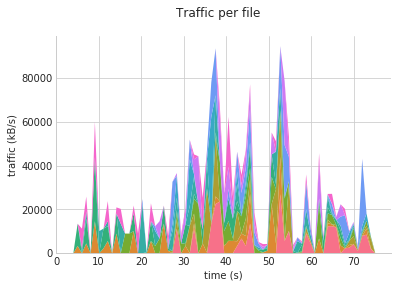

In [7]:
sns.set_style('whitegrid')
f, ax = plt.subplots()

ax.stackplot(x[1:], y, colors=sns.color_palette("husl", n_colors=n_files))

ax.set_xlabel('time (s)')
ax.set_ylabel('traffic (kB/s)')
ax.set_xlim(0, )
ax.set_ylim(0, )
plt.suptitle("Traffic per file")

sns.despine()
plt.savefig("outputs/"+conf['experiment_name']+'/traffic_per_file.svg')
plt.show()

### Messages' RTT

In [8]:
messages_id = np.unique(devices_df['mess_id'])
transfer_times = pd.DataFrame()
#transfer_times = np.zeros(len(messages_id), dtype=np.float64)

for i, m_id in enumerate(messages_id):
    times = [None] * 2
    for typ in [1, 2]:
        data = devices_df[(devices_df['mess_id'] == m_id) &
                          (devices_df['type'] == typ)]['t']
        
        if len(data) != 0:
            times[typ - 1] = max(data) - min(data)
            transfer_times = transfer_times.append(pd.Series({
                't': times[typ - 1], 
                'type': typ}), ignore_index=True)
            
    if times[0] is not None and times[1] is not None:
        transfer_times = transfer_times.append(pd.Series({
                't': sum(times), 
                'type': 3}), ignore_index=True)


def to_cdf(data):
    data_size = len(data)
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)
    counts, bin_edges = np.histogram(data, bins=bins, density=False)

    counts=counts.astype(float)/data_size

    # Find the cdf
    cdf = np.cumsum(counts)
    
    return cdf, bins

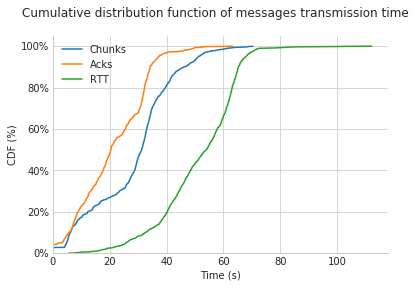

In [9]:
f, ax = plt.subplots()

# Plot the cdf
cdf, bins = to_cdf(transfer_times[transfer_times['type'] == 1]['t'])
ax.plot(bins[0:-1], cdf, label="Chunks")
cdf, bins = to_cdf(transfer_times[transfer_times['type'] == 2]['t'])
ax.plot(bins[0:-1], cdf, label="Acks")
cdf, bins = to_cdf(transfer_times[transfer_times['type'] == 3]['t'])
ax.plot(bins[0:-1], cdf, label="RTT")

ax.set_xlabel('Time (s)')
ax.set_xlim(0,)
ax.set_ylabel('CDF (%)')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_ylim(0,)
ax.legend()
plt.suptitle('Cumulative distribution function of messages transmission time')


sns.despine()
plt.savefig('/messages_rtt_cdf.svg')
plt.show()

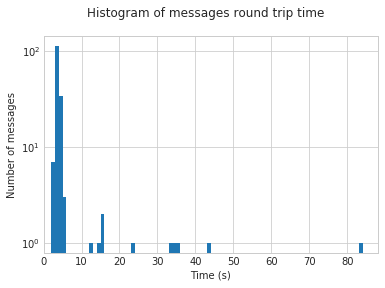

In [53]:
f, ax = plt.subplots()

ax.hist(transfer_times, bins=range(1, math.ceil(max(transfer_times))+1))

ax.set_xlabel('Time (s)')
ax.set_xlim(0,)
ax.set_ylabel('Number of messages')
ax.set_yscale('log')
plt.suptitle('Histogram of messages round trip time')

plt.savefig("outputs/"+conf['experiment_name']+'/messages_rtt_hist.svg')
plt.show()

### File reception time

In [78]:
messages_id.shape

(148,)

In [10]:
files_id = np.unique(devices_df['file_id'])

file_transfer_time = []
for f_id in files_id:
    beginning_time = devices_df[(devices_df['file_id'] == f_id) & (devices_df['type'] == 1) & (devices_df['sent'] != 0)]['t'].min()
    completion_time = devices_df[(devices_df['file_id'] == f_id) & (devices_df['type'] == 2) & (devices_df['received'] != 0)]['t'].max()
    
    file_transfer_time.append(completion_time - beginning_time)

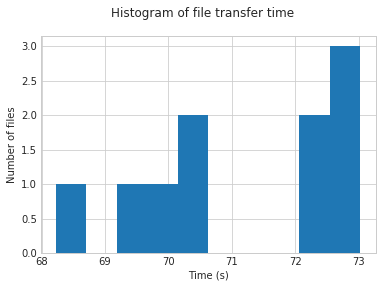

In [12]:
f, ax = plt.subplots()

ax.hist(file_transfer_time, bins=10)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Number of files')
plt.suptitle('Histogram of file transfer time')

plt.savefig("outputs/"+conf['experiment_name']+'/files_time_hist.svg')
plt.show()